# AquaCrop-OSPy: Bridging the gap between research and practice in crop-water modelling


<a href="https://colab.research.google.com/github/aquacropos/aquacrop/aquacrop/docs/notebooks/AquaCrop_OSPy_Notebook_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

This series of notebooks provides users with an introduction to AquaCrop-OSPy, an open-source Python implementation of the U.N. Food and Agriculture Organization (FAO) AquaCrop model. AquaCrop-OSPy is accompanied by a series of Jupyter notebooks, which guide users interactively through a range of common applications of the model. Only basic Python experience is required, and the notebooks can easily be extended and adapted by users for their own applications and needs.


This notebook series consists of four parts:

1.   <a href=https://colab.research.google.com/github/thomasdkelly/aquacrop/blob/master/tutorials/AquaCrop_OSPy_Notebook_1.ipynb>Running an AquaCrop-OSPy model</a>
2.   <a href=https://colab.research.google.com/github/thomasdkelly/aquacrop/blob/master/tutorials/AquaCrop_OSPy_Notebook_2.ipynb>Estimation of irrigation water demands</a>
3.   <a href=https://colab.research.google.com/github/thomasdkelly/aquacrop/blob/master/tutorials/AquaCrop_OSPy_Notebook_3.ipynb>Optimisation of irrigation management strategies</a>
4.  <a href=https://colab.research.google.com/github/thomasdkelly/aquacrop/blob/master/tutorials/AquaCrop_OSPy_Notebook_4.ipynb>Projection of climate change impacts</a>


# Notebook 4: Irrigation demands under different climate change scenarios

In this notebook, we show how AquaCrop-OSPy can be used to simulate impacts of climate change on crop production and irrigation water demands. Climate change is a major driver of production and water scarcity for agriculture globally, and data generated can thus play an important role in designing effective adaptation measures to support farmers and rural economies.

The example presented here focuses on a case study of maize production in the central United States. Baseline data from this region (1982-2018) is used to generate future climate projections using the LARS weather generator. Projections are generated for the periods (2021-2040, 2041-2060, 2061-2080) and for emissions scenarios RCP4.5 and RCP8.5 based on outputs from the EC-EARTH climate model. 

First install and import AquaCrop-OSPy

In [1]:
# !pip install aquacrop tqdm matplotlib seaborn

In [27]:
from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent,CO2, IrrigationManagement
from aquacrop.utils import get_filepath, prepare_lars_weather,select_lars_wdf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm # progress bar


Given the popularity of using LARS-WG for this type of analyis, AquaCrop-OSPy contains a built in function for reading LARS generated outputs. These outputs consist of daily climate projections of precipitation, minimum and maximum temperature and solar radiation. Using the Hargreaves ETo method these values were used to estimate the reference evapotranspiration, resulting in a weather DataFrame in the format required by AquaCrop-OSPy. 

The cell below imports the baseline data from Champion, Nebraska

In [11]:
# get baseline lars data
lars_fp=get_filepath('CP.dat')
lars_base=prepare_lars_weather(lars_fp,-1,False,order=['year', 'jday', 'maxTemp', 'minTemp', 'precip','rad',])

In [12]:
lars_base.head()

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,3.89,17.22,0.00,1.868710,1981-05-20
1,6.67,21.67,0.00,2.665948,1981-05-21
2,5.56,25.00,2.01,3.420034,1981-05-22
3,5.56,19.44,0.00,2.440758,1981-05-23
4,5.56,24.44,0.00,3.520489,1981-05-24


For each combination of climate scenario and projection period, read in climate data and save the weather DataFrame.

In [13]:
rcp_list = [45,85]
yr_list = [2030,2050,2070]
yr_range_list = ['2021-2040','2041-2060','2061-2080']

label_list=[]
wdf_list = []
all_year_list=[]
for yr,yr_range in zip(yr_list,yr_range_list):
    for rcp in rcp_list:
        wdf =prepare_lars_weather(get_filepath(f'CP_EC-EARTH[CP,RCP{rcp},{yr_range}]WG.dat'),
                              yr,True,["simyear","jday","minTemp","maxTemp","precip","rad"])
        wdf_list.append(wdf)
        label_list.append(f'RCP{rcp/10},\n{yr_range}')
        all_year_list.append(yr)

In [14]:
label_list

['RCP4.5,\n2021-2040',
 'RCP8.5,\n2021-2040',
 'RCP4.5,\n2041-2060',
 'RCP8.5,\n2041-2060',
 'RCP4.5,\n2061-2080',
 'RCP8.5,\n2061-2080']

In [15]:
# co2 concentrations for the scenarios listed in order
co2_list = [435,449,487,541,524,677]

The LARS generated output files in this example comprise of 100 years of daily weather data (denoted by the 'simyear' column). To select any one of these years, use the `select_lars_wdf` function.

In [16]:
wdf_list[0].head()

,simyear,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,1,-1.3,-0.4,0.0,0.113671,2030-01-01
1,1,-10.2,19.7,0.0,3.438354,2030-01-02
2,1,-8.2,9.0,0.0,1.568464,2030-01-03
3,1,-5.0,17.3,0.0,2.585045,2030-01-04
4,1,-7.6,0.0,0.0,0.573125,2030-01-05


In [17]:
select_lars_wdf(wdf_list[0],simyear=3).head()

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,-12.3,2.5,0.0,1.030637,2030-01-01
1,-9.0,-6.0,0.0,0.171382,2030-01-02
2,-8.4,11.5,0.0,1.889522,2030-01-03
3,-11.6,-6.6,0.0,0.291564,2030-01-04
4,-14.7,7.7,0.0,1.671600,2030-01-05


Now that all the climate data is ready, we can define our crop, soil, initial water content and irrigation management. In this example we will use the AquaCrop default Maize crop in calendar day mode. The reason for using calendar day mode is so that the growing season will be the same length in each scenario. 

We choose a Clay loam soil starting at Field Capacity, and an irrigation policy that irrigates if the soil drops below 70% total available water (essentially meeting full crop-water requirements). 

In [18]:
crop=Crop('Maize',planting_date='05/01',
               CalendarType=1,Emergence = 6,Senescence=107,
               MaxRooting=108,Maturity=132,HIstart=66,
               Flowering=13,YldForm=61,CDC=0.117,CGC=0.163)
          
soil=Soil('ClayLoam')
init_wc = InitialWaterContent() # default is field capacity
irrmngt=IrrigationManagement(1,SMT=[70]*4)

Run the simulation for the baseline period and save the yields and total irrigation.

In [19]:
#run for baseline scenario
model=AquaCropModel('1982/05/01','2018/10/30',lars_base,soil,crop,
                    init_wc,irrigation_management=irrmngt)

model.run_model(till_termination=True)

True

In [20]:
baseline_yields = list(model.get_simulation_results()['Yield (tonne/ha)'].values)
baseline_tirrs = list(model.get_simulation_results()['Seasonal irrigation (mm)'].values)
baseline_labels = ['Baseline']*len(baseline_tirrs)

Define `run_gen_model` function that runs AquaCrop-OSPy for all 100 generated years of a climate scenario and future period (e.g. 2050 at RCP4.5), saving the yields and total irrigation.

In [30]:
def run_gen_model(all_wdf,co2conc,year):
    gen_yields=[]
    gen_tirrs=[]
    for i in range(100):
        wdf = select_lars_wdf(all_wdf,i+1)

        co2 = CO2(constant_conc=True)
        co2.current_concentration = co2conc
        
        model=AquaCropModel(f'{year}/05/01',f'{year}/10/30',wdf,soil,crop,
                            InitialWaterContent(),irrigation_management=irrmngt,co2_concentration=co2)

        model.run_model(till_termination=True)

        gen_yields.append(model.get_simulation_results()['Yield (tonne/ha)'].mean())
        gen_tirrs.append(model.get_simulation_results()['Seasonal irrigation (mm)'].mean())

    return gen_yields,gen_tirrs

For each combination of climate scenario and projection period, run AquaCrop-OSPy and save results.

In [31]:
all_ylds = []
all_tirrs = []
all_labels = []
for i in (range(6)):
    year = all_year_list[i]
    wdf = wdf_list[i]
    co2 = co2_list[i]
    label=label_list[i]

    yld_list,tirr_list = run_gen_model(wdf,co2,year)

    all_ylds.extend(yld_list)
    all_tirrs.extend(tirr_list)
    all_labels.extend([label]*len(yld_list))


Combine projection results with baseline.

In [32]:
all_ylds = baseline_yields+all_ylds
all_tirrs = baseline_tirrs+all_tirrs
all_labels = baseline_labels+all_labels

In [33]:
import pandas as pd

df = pd.DataFrame([all_ylds,all_tirrs,all_labels]).T
df.columns = ['Yield','Tirr','Label']
df.head()

,Yield,Tirr,Label
0,12.641796,50.0,Baseline
1,12.88586,75.0,Baseline
2,13.601316,175.0,Baseline
3,13.251319,175.0,Baseline
4,13.747646,90.65583,Baseline


Visualize results for all projections and baselines.

Text(0, 0.5, 'Total Irrigation (ha-mm)')

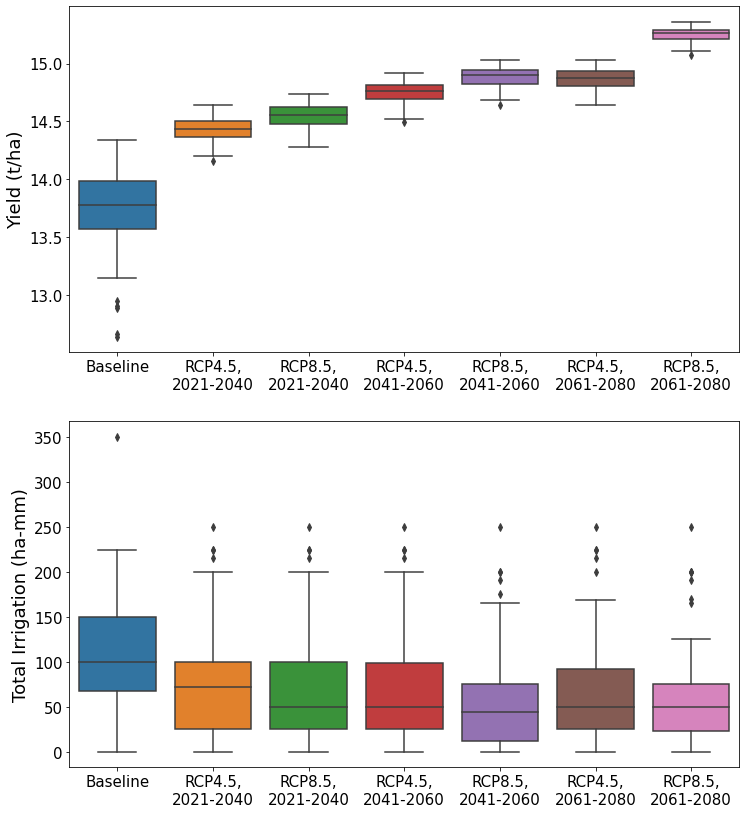

In [34]:
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# create figure 
fig,ax=plt.subplots(2,1,figsize=(12,14))

# create box plots
sns.boxplot(data=df,x='Label',y='Yield',ax=ax[0])
sns.boxplot(data=df,x='Label',y='Tirr',ax=ax[1])

# labels and fontsize

ax[0].tick_params(labelsize=15)
ax[0].set_xlabel(' ')
ax[0].set_ylabel('Yield (t/ha)',fontsize=18)

ax[1].tick_params(labelsize=15)
ax[1].set_xlabel(' ')
ax[1].set_ylabel('Total Irrigation (ha-mm)',fontsize=18)

# Appendix: Precipitation and ET changes

In [35]:
all_precip = []
all_et = []
all_new_labels = []
for year in range(1982,2019):
    #run for baseline scenario
    wdf = lars_base[lars_base.Date>f'{year}-05-01']
    wdf = wdf[wdf.Date<f'{year}-10-31']

    all_precip.extend([wdf.Precipitation.mean()])
    all_et.extend([wdf.ReferenceET.mean()])
    all_new_labels.extend(['baseline'])

In [36]:
for i in range(6):

    year = all_year_list[i]
    wdf = wdf_list[i]
    co2 = co2_list[i]
    label=label_list[i]

    wdf = wdf[wdf.Date>f'{year}-05-01']
    wdf = wdf[wdf.Date<f'{year}-10-31']

    #print(wdf.ReferenceET.mean())

    precip_list = list(wdf.groupby('simyear').mean().Precipitation.values)
    et_list = list(wdf.groupby('simyear').mean().ReferenceET.values)


    all_precip.extend(precip_list)
    all_et.extend(et_list)
    all_new_labels.extend([label]*len(et_list))


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
import pandas as pd

df = pd.DataFrame([all_precip,all_et,all_new_labels]).T
df.columns = ['precip','et','Label']
df.head()

,precip,et,Label
0,2.043242,2.956046,baseline
1,1.173352,3.073606,baseline
2,0.894066,3.21152,baseline
3,1.567473,3.21065,baseline
4,2.312967,3.272438,baseline


Text(0, 0.5, 'ETo (mm/ha)')

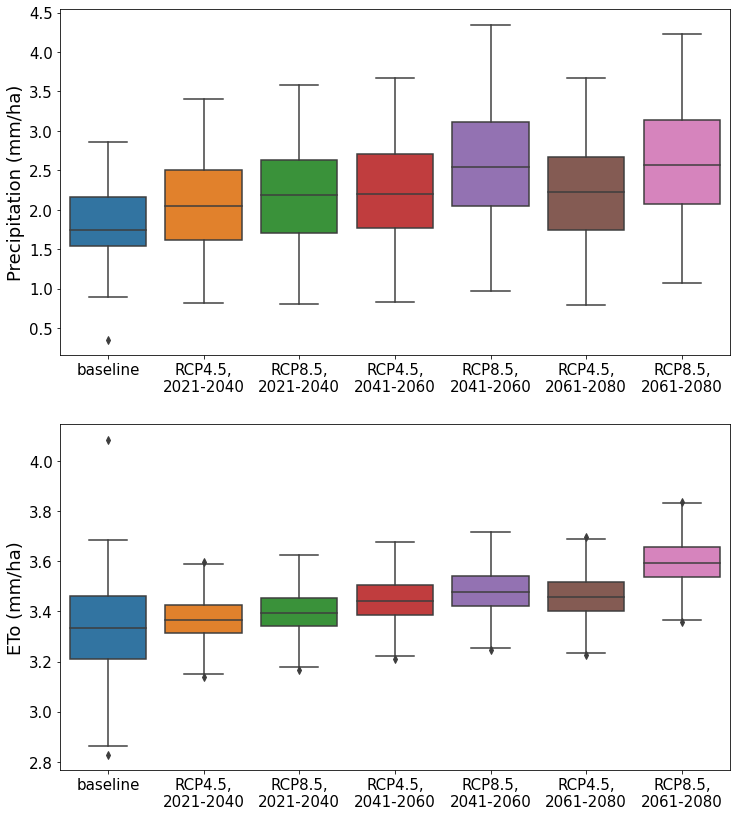

In [ ]:
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# create figure 
fig,ax=plt.subplots(2,1,figsize=(12,14))

# create box plots
sns.boxplot(data=df,x='Label',y='precip',ax=ax[0])
sns.boxplot(data=df,x='Label',y='et',ax=ax[1])

# labels and fontsize

ax[0].tick_params(labelsize=15)
ax[0].set_xlabel(' ')
ax[0].set_ylabel('Precipitation (mm/ha)',fontsize=18)

ax[1].tick_params(labelsize=15)
ax[1].set_xlabel(' ')
ax[1].set_ylabel('ETo (mm/ha)',fontsize=18)